# Search through videos using fast.ai

This notebook will walk you through a simple example that trains a model to determine if there's a bicycle in an image and then use that to find bicycles in a video.

This work is based on the early lessons in [Practical Deep Learning for Coders](https://course.fast.ai/), taught online by Jeremy Howard. I **highly** recommend this free online course.

## Using this notebook

Essentially you need a computer that's running a GPU running fast.ai. There are a few ways to do this without owning a computer with a GPU (I certainly don't). There are [lots of options](https://course.fast.ai/index.html). I like to use use [the Amazon EC2 setup](https://course.fast.ai/start_aws.html), which is probably the most complicated. In most of these cases, you'll just clone [the workshop repository](https://github.com/Quartz/aistudio-workshops) and get the notebook running.

I'm also tailoring this notebook for use with [Google Colaboratory](https://colab.research.google.com), which as of this writing is the fastest, cheapest (free) way to get going.


### If you're using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes).

There are great steps on the fast.ai site for [getting started with fast.ai an Google Colab](https://course.fast.ai/start_colab.html). 

Those instructions will show you how to save your own copy of this _notebook_ to Google Drive.

They also tell you how to save a copy of your _data_ to Google Drive (Step 4), which is unneccesary for this workshop. 

In [ ]:
## ALL GOOGLE COLAB USERS RUN THIS CELL

## This runs a script that installs fast.ai
!curl -s https://course.fast.ai/setup/colab | bash

### If you are _not_ using Google Colaboratory ...

Run the cell below.

In [ ]:
## NON-COLABORATORY USERS SHOULD RUN THIS CELL
%reload_ext autoreload
%autoreload 2
%matplotlib inline
!sudo apt --yes install ffmpeg

### Everybody do this ...

In [1]:
## AND *EVERYBODY* SHOULD RUN THIS CELL

import glob
from fastai.vision import *
from fastai.metrics import error_rate
from IPython.display import Image as Show

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:2.8.15-0ubuntu0.16.04.1).
The following packages were automatically installed and are no longer required:
  libaio1 librados2 librbd1 librdmacm1 linux-aws-headers-4.4.0-1077
  linux-aws-headers-4.4.0-1079 linux-aws-headers-4.4.0-1083
  linux-aws-headers-4.4.0-1084 linux-aws-headers-4.4.0-1085
  linux-aws-headers-4.4.0-1087 linux-headers-4.4.0-1077-aws
  linux-headers-4.4.0-1079-aws linux-headers-4.4.0-1083-aws
  linux-headers-4.4.0-1084-aws linux-headers-4.4.0-1085-aws
  linux-headers-4.4.0-1087-aws linux-image-4.4.0-1077-aws
  linux-image-4.4.0-1079-aws linux-image-4.4.0-1083-aws
  linux-image-4.4.0-1084-aws linux-image-4.4.0-1085-aws
  linux-image-4.4.0-1087-aws linux-modules-4.4.0-1077-aws
  linux-modules-4.4.0-1079-aws linux-modules-4.4.0-1083-aws
  linux-modules-4.4.0-1084-aws linux-modules-4.4.0-1085-aws
  linux-modules-4.4.0-1087-aws
Use 'sudo a

## The Plan

The goal is to see if we can spot something specific in a video. This would be useful especially if you had hours of video you didn't have time to watch.

In our case, we'll try to spot bicycles in this video:


Our plan will be:

- Download a computer-vision model pre-trained on 14 million images
- Further train that model on images containing "yes bikes" and "no bikes"
- Chop up our video into frames
- Use the model to detect bikes in frames

## The Data

Let's get the video and the "yes bikes" and "no bikes" images, which are in the folders `1` and `0` respectively.

In [4]:
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
!unzip bikes_data.zip > /dev/null
print('Done!')

--2019-08-15 19:21:26--  https://qz-aistudio-public.s3.amazonaws.com/workshops/bikes_data.zip
Resolving qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)... 52.216.129.43
Connecting to qz-aistudio-public.s3.amazonaws.com (qz-aistudio-public.s3.amazonaws.com)|52.216.129.43|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 326414092 (311M) [application/zip]
Saving to: ‘bikes_data.zip’

bikes_data.zip      100%[===================>] 311.29M  89.2MB/s    in 3.5s    

2019-08-15 19:21:29 (89.0 MB/s) - ‘bikes_data.zip’ saved [326414092/326414092]

Done!


Now you have a subdirectory called `bikes_data` which contains two folders (`0` and `1`) and the movie.

In [ ]:
%ls bikes_data

In [ ]:
%ls bikes_data/images

In [ ]:
%ls bikes_data/images/1

Let's take a looks at one ...

In [ ]:
Show(filename='bikes_data/images/1/IMG_1494.JPG')

Notebooks aren't great at playing videos, so I posted `bikes_data/intersection_movie.mov` on [Vimeo](https://vimeo.com/354069170).

Now we need to load our image data in a format that's ready for the training code. We do that with fast.ai's data block.

In [ ]:
data_path = Path('./bikes_data/images') ## The path for our data

np.random.seed(12)

data = (ImageList.from_folder(data_path)  #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct()  #How to split in train/valid? -> do it *randomly* (Not by folder)
        .label_from_folder()         #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(), size=(224,224))  #Data transforms applied, size of images shrink to 224
        .databunch(bs=48))

In [ ]:
data_path.ls()

In [ ]:
data.show_batch(rows=3)

In [ ]:
# Let's be sure to check our classes
print(data.classes)

## Training

Now we will start training our model. We will use a convolutional neural network backbone and a fully connected head with a single hidden layer as a classifier. Don't know what these things mean? Most people don't! For a deeper dive, check out the fast.ai courses.

But for now, you need to know that we are building a model which will take images as input and will output the predicted probability for each of the categories: 0 and 1

### Transfer learning with resnet34

Training a computer-vision mode from scratch to solve our problem would take thousands of images. Maybe more. Instead we take advantage of an existing model that was trained to detect objects -- from planes, to cars, to dogs, to birds -- by processing millions of images. This model is called "resnet34."

With fast.ai we can infuse this model with our images (and their labels). This takes advantage of all of resnet34's "knowledge" of image-detection and tacks on our particular problem. This technique is called "transfer learning."

First we load our `data` and `model.resnet34` together into a training model known as a "learner."

In [ ]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

We will train for 6 epochs (6 cycles through all our data).

In [ ]:
learn.fit_one_cycle(6)

#### How are we doing?

So far, we have a pretty good error rate. It's actually possible to do even better, but we'll stick with this for now.

We can take a look to see where the model was most confused, and whether what the model predicted was reasonable or not.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

In [ ]:
interp.plot_top_losses(9, heatmap=True)

We can also see the situations in which it was most confused:

In [ ]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's save what we have in case we mess it up later!

In [ ]:
learn.save('bikes-1')

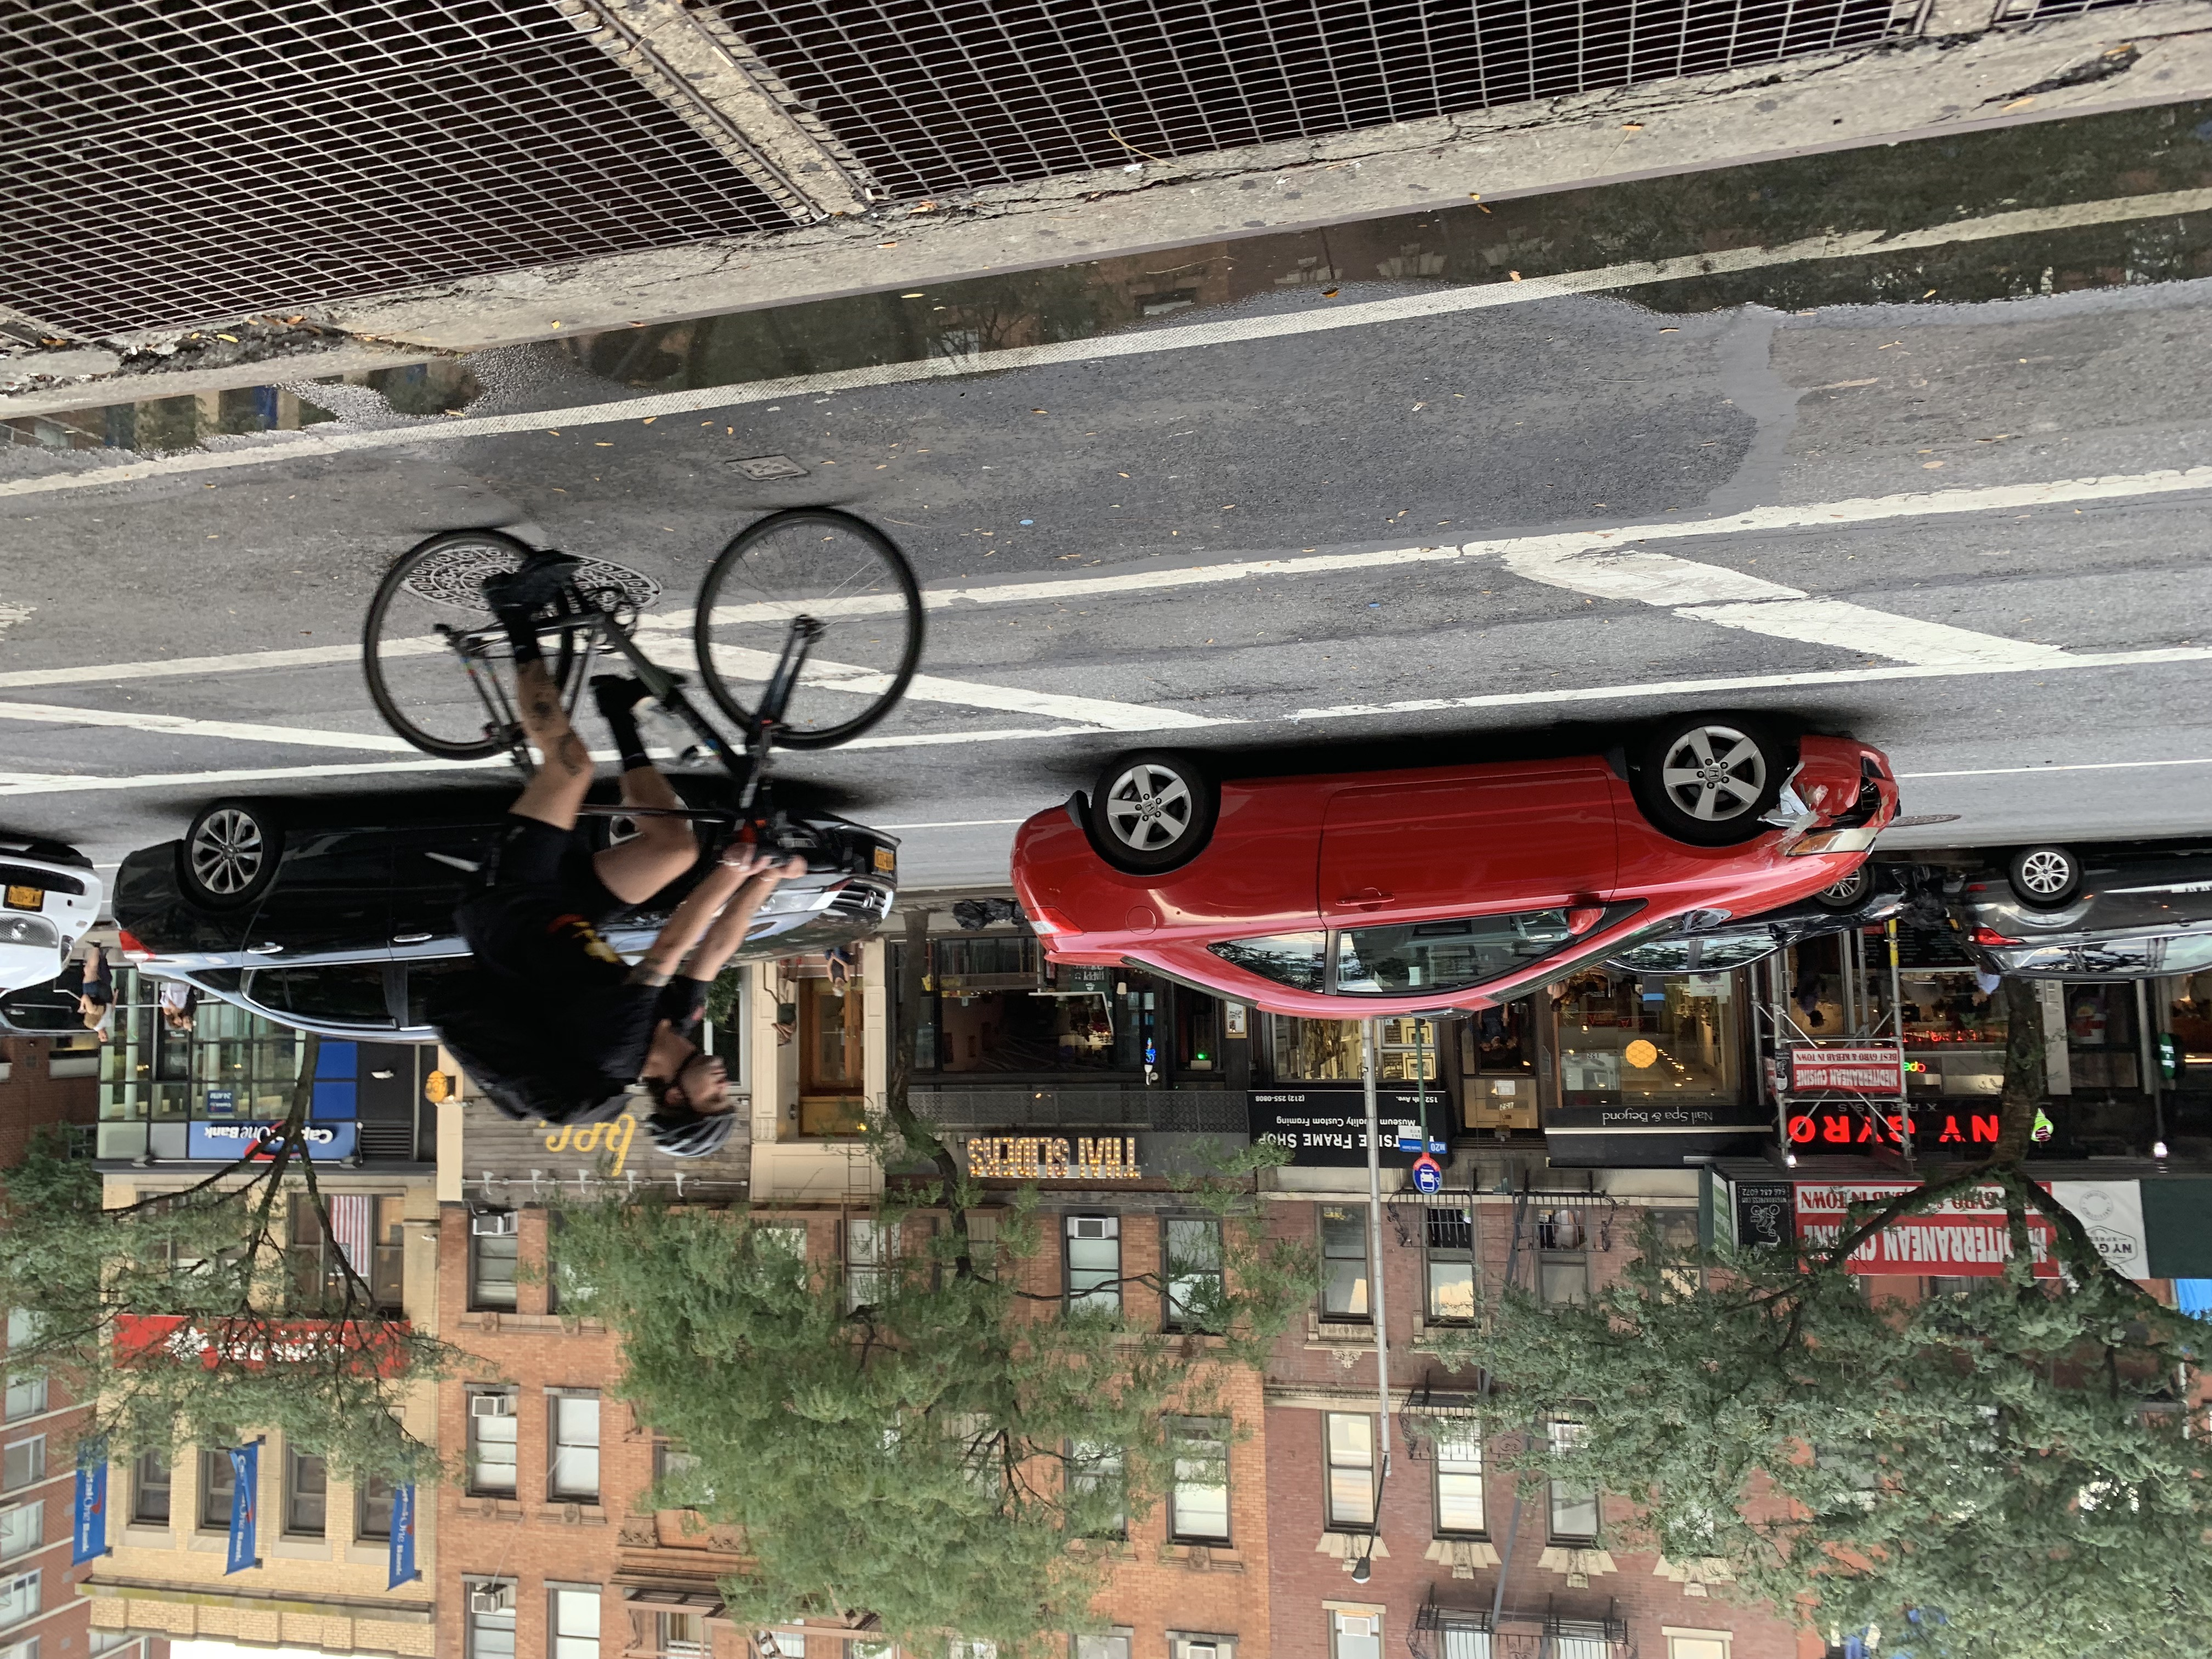

In [5]:
Show(filename='bikes_data/never_seen_image.jpg', width=640)

In [ ]:
img = open_image('bikes_data/never_seen_image.jpg')

In [ ]:
learn.predict(img)

In [ ]:
pred_class,pred_idx,outputs = learn.predict(img)

In [ ]:
pred_class

In [ ]:
int(pred_class)

In [ ]:
outputs

In [ ]:
outputs[1]

We're also going to _export_ the entire package as a "pickle" file called `export.pkl`

**Warning for Google Colab users!** Later, when you've done more fine tuning and want to save what you've done, you need to give permission for this notebook to write files to your Google Drive. In that case, you'll want to run the next cell and follow the permission-granting steps. For now, you can skip this.

In [ ]:
## THIS CELL WILL ALLOW GOOGLE COLAB USERS SAVE MODELS TO YOUR GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
save_path = Path(root_dir + 'ai-bikes/')
save_path.mkdir(parents=True, exist_ok=True)

In [ ]:
learn.export("export.pkl")

## Search our video

Now we'll apply our model to our video! First we need to turn the video into a bunch of images using `ffmpeg`, which we loaded at the beginning of this notebook.

In [ ]:
!ffmpeg -i bikes_data/intersection_movie.mov -vf fps=1 -vsync 0 myframe%04d.jpg

In [ ]:
%ls

In [ ]:
glob.glob('myframe*.*')

In [ ]:
# learn = load_learner(path)  # this gets the exported pickle file, which is stored in the image data path

In [ ]:
file_list = sorted(glob.glob('myframe*.*'))

for file in file_list:
    image = open_image(file)
    pred_class,pred_idx,outputs = learn.predict(image)
        
    if int(pred_class) == 1 and outputs[1] > 0.85:
        print(f'Bike detected in {file} with confidence {outputs[1]}')
    

In [ ]:
Show(filename='myframe0025.jpg')